<a href="https://colab.research.google.com/github/ducpc99/CNNs_with_Cifar10/blob/main/CNNs_with_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

Define CNN Architecture

In [ ]:
def load_cifar10(batch_size=64, num_workers=2):
    # Define transforms for the training and test sets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 training dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    # Load CIFAR-10 test dataset
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    # Class labels for CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the Model

In [ ]:
def train(model, trainloader, criterion, optimizer, epochs, device):
    train_losses = []
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                avg_loss = running_loss / 100
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                train_losses.append(avg_loss)
                running_loss = 0.0

    return train_losses

Evaluate the Model

In [ ]:
def evaluate(model, testloader, device):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return accuracy

In [ ]:
# Train the model
trainloader, testloader, classes = load_cifar10(batch_size=64, num_workers=2)
print("Training on:", device)
train_losses = train(model, trainloader, criterion, optimizer, epochs=10, device=device)

# Evaluate the model
accuracy = evaluate(model, testloader, device)
print(f'Accuracy on test set: {accuracy:.2f}%')

100%|██████████| 170498071/170498071 [00:04<00:00, 41327935.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training on: cuda
[1,   100] loss: 2.019
[1,   200] loss: 1.766
[1,   300] loss: 1.644
[1,   400] loss: 1.535
[1,   500] loss: 1.482
[1,   600] loss: 1.422
[1,   700] loss: 1.398
[2,   100] loss: 1.284
[2,   200] loss: 1.265
[2,   300] loss: 1.261
[2,   400] loss: 1.208
[2,   500] loss: 1.230
[2,   600] loss: 1.192
[2,   700] loss: 1.189
[3,   100] loss: 1.102
[3,   200] loss: 1.062
[3,   300] loss: 1.065
[3,   400] loss: 1.052
[3,   500] loss: 1.033
[3,   600] loss: 1.053
[3,   700] loss: 1.032
[4,   100] loss: 0.964
[4,   200] loss: 0.952
[4,   300] loss: 0.940
[4,   400] loss: 0.955
[4,   500] loss: 0.917
[4,   600] loss: 0.913
[4,   700] loss: 0.919
[5,   100] loss: 0.860
[5,   200] loss: 0.880
[5,   300] loss: 0.866
[5,   400] loss: 0.856
[5,   500] loss: 0.848
[5,   600] loss: 0.829
[5,   700] loss: 0.853
[6,   100] loss: 0.784
[6,   200] loss: 0.787
[6,   300] loss: 0.790
[6,   400] loss: 0.

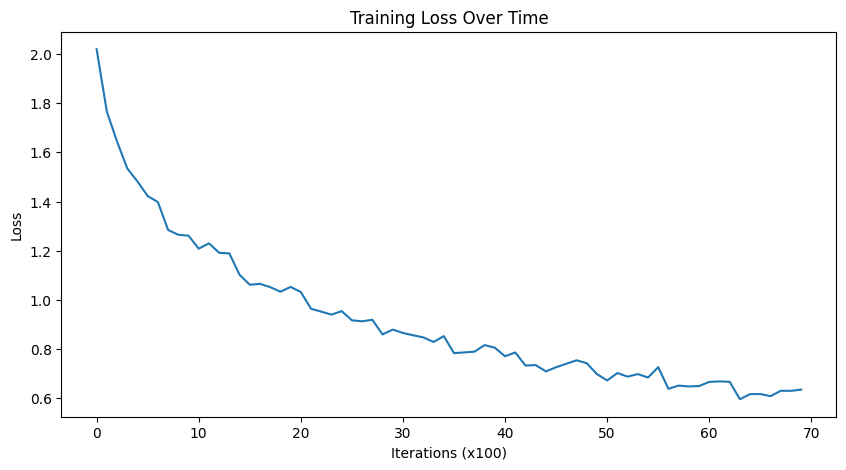

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.show()

Display Predictions

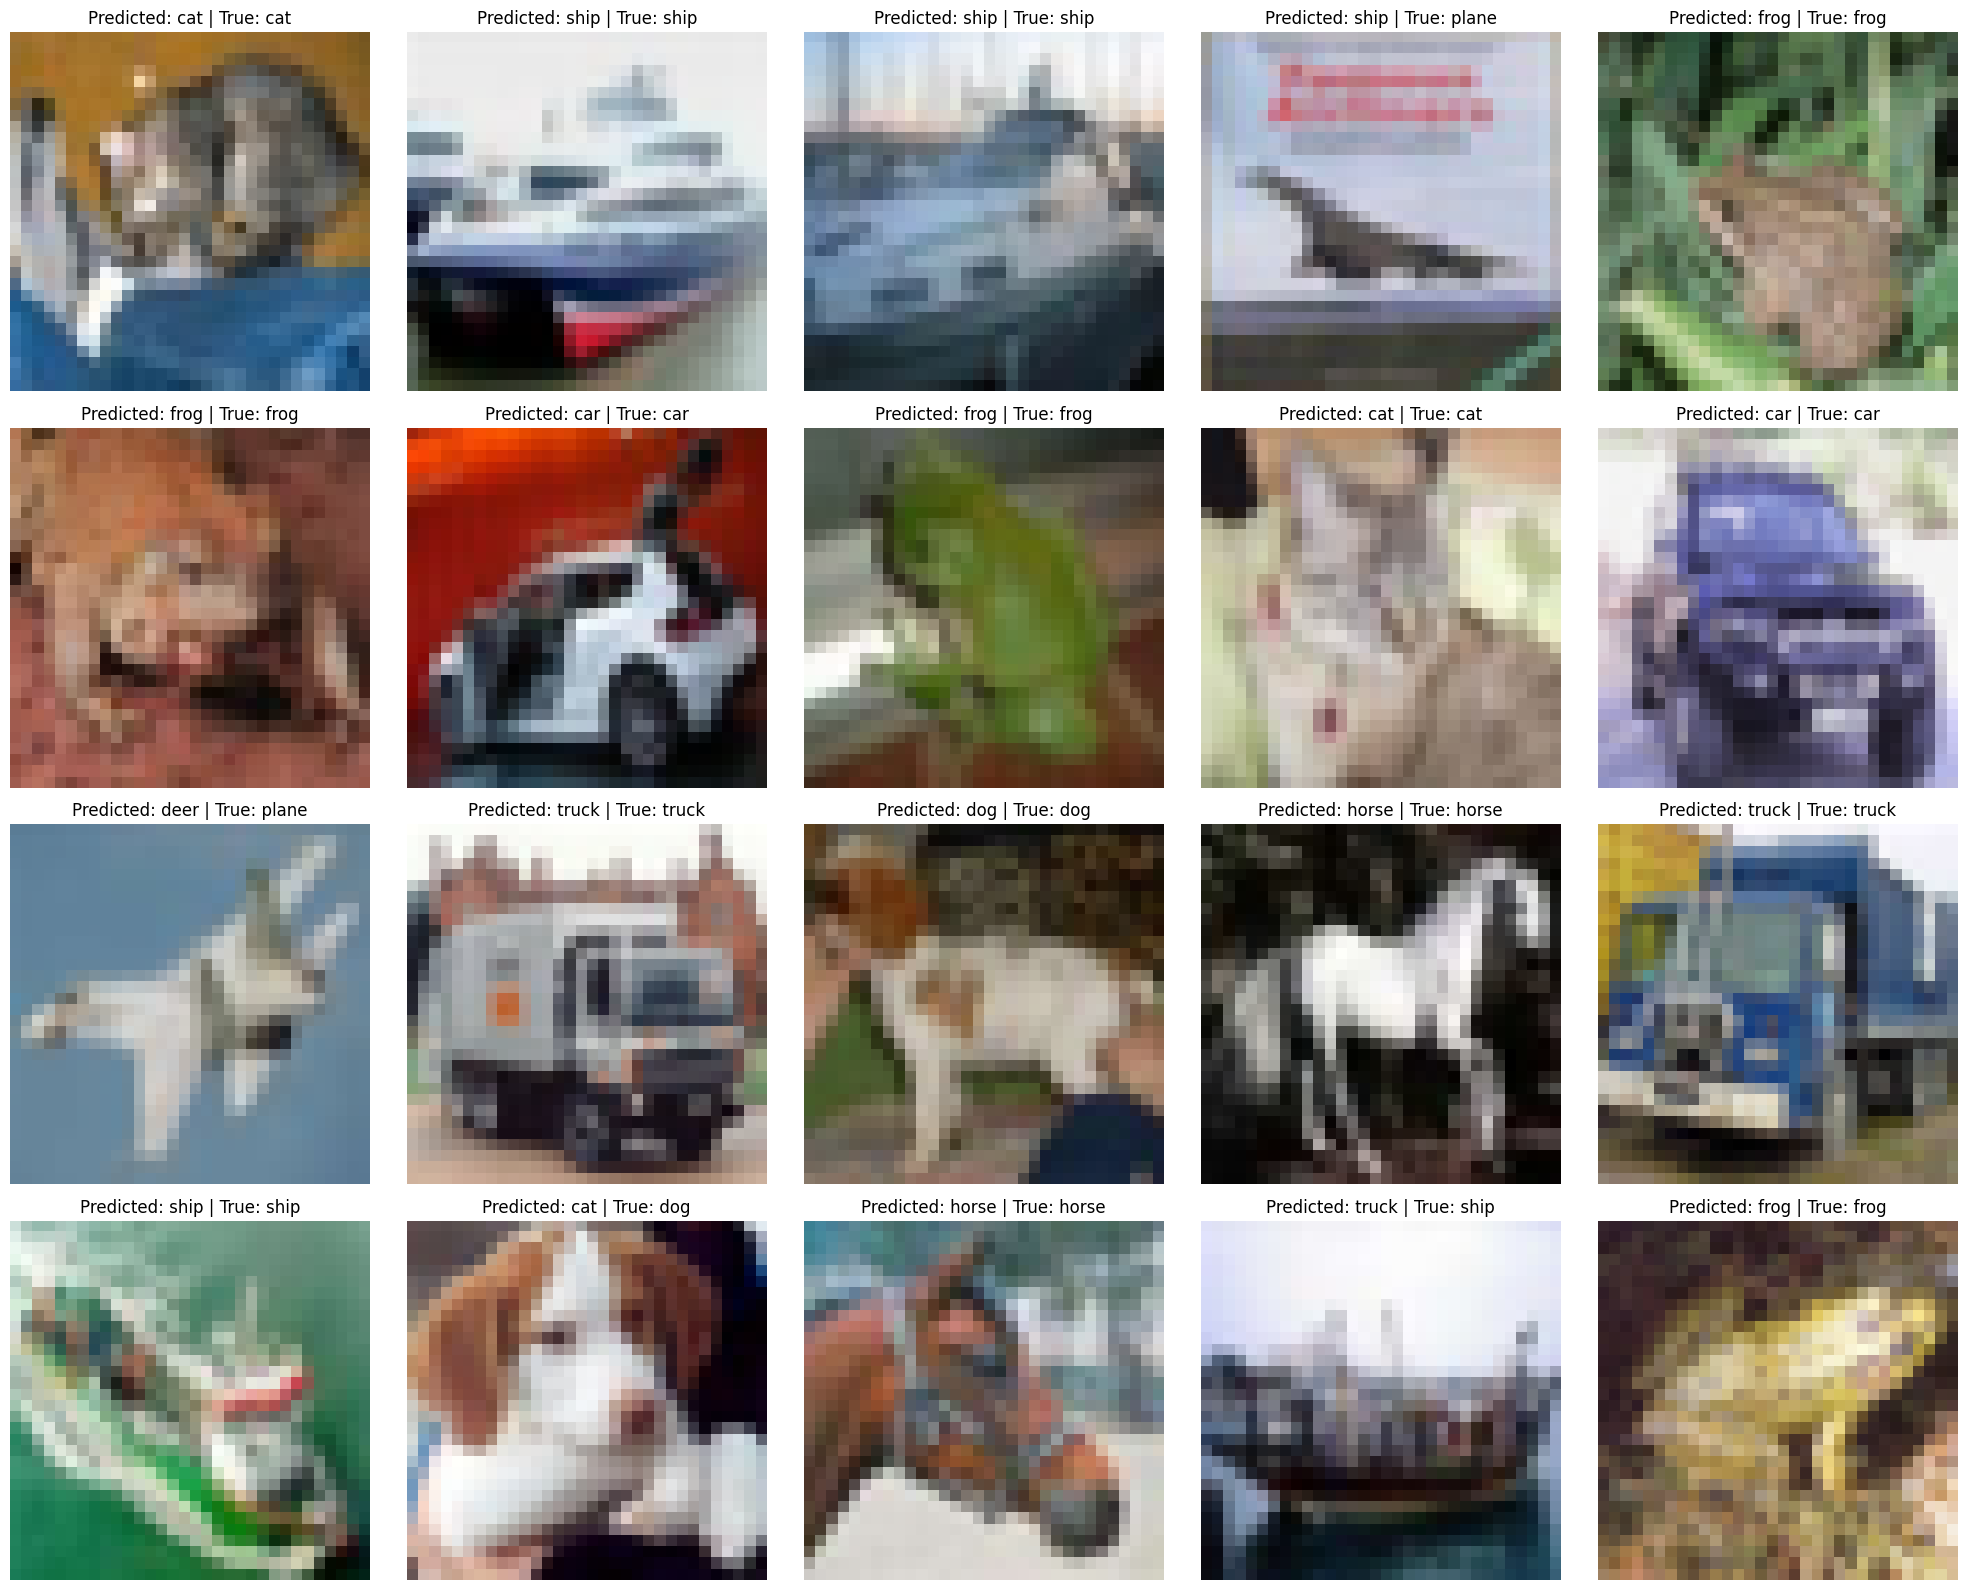

In [ ]:
def display_predictions(testloader, model, device, num_images):
    images, labels = next(iter(testloader))
    images = images.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    rows = (num_images + 4) // 5
    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        image = images[i].cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = (image * 0.5) + 0.5

        plt.subplot(rows, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Predicted: {classes[predicted[i]]} | True: {classes[labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_predictions(testloader, model, device, num_images=20)

Tuning

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Training on: cuda
[1,   100] loss: 2.293
[1,   200] loss: 2.157
[1,   300] loss: 1.979
[1,   400] loss: 1.863
[1,   500] loss: 1.772
[1,   600] loss: 1.691
[1,   700] loss: 1.683
[1,   800] loss: 1.555
[1,   900] loss: 1.578
[1,  1000] loss: 1.507
[1,  1100] loss: 1.484
[1,  1200] loss: 1.448
[1,  1300] loss: 1.408
[1,  1400] loss: 1.418
[1,  1500] loss: 1.350
[2,   100] loss: 1.382
[2,   200] loss: 1.317
[2,   300] loss: 1.260
[2,   400] loss: 1.289
[2,   500] loss: 1.280
[2,   600] loss: 1.237
[2,   700] loss: 1.237
[2,   800] loss: 1.258
[2,   900] loss: 1.224
[2,  1000] loss: 1.208
[2,  1100] loss: 1.190
[2,  1200] loss: 1.134
[2,  1300] loss: 1.180
[2,  1400] loss: 1.141
[2,  1500] loss: 1.179
[3,   100] loss: 1.114
[3,   200] loss: 1.072
[3,   300] loss: 1.074
[3,   400] loss: 1.101
[3,   500] loss: 1.044
[3,   600] loss: 1.084
[3,   700] loss: 1.035
[3,   800] loss: 1.027
[3,   900] loss: 1.045
[3,  1000] loss: 1.081
[3,  1100] loss: 1.005
[

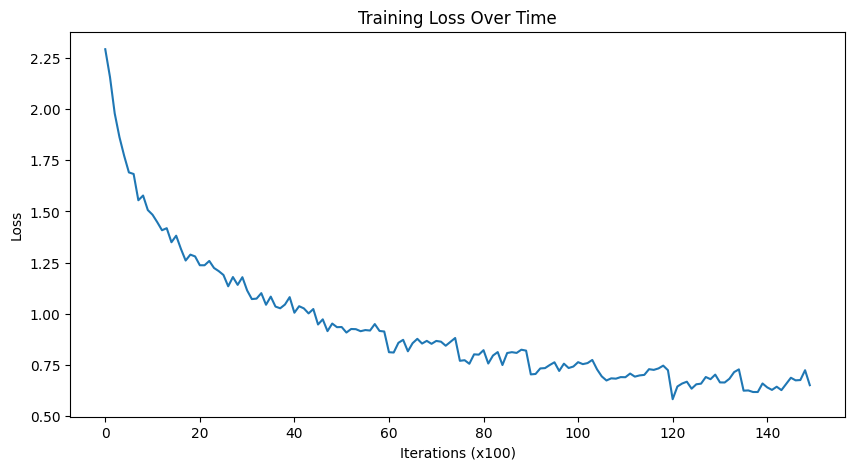

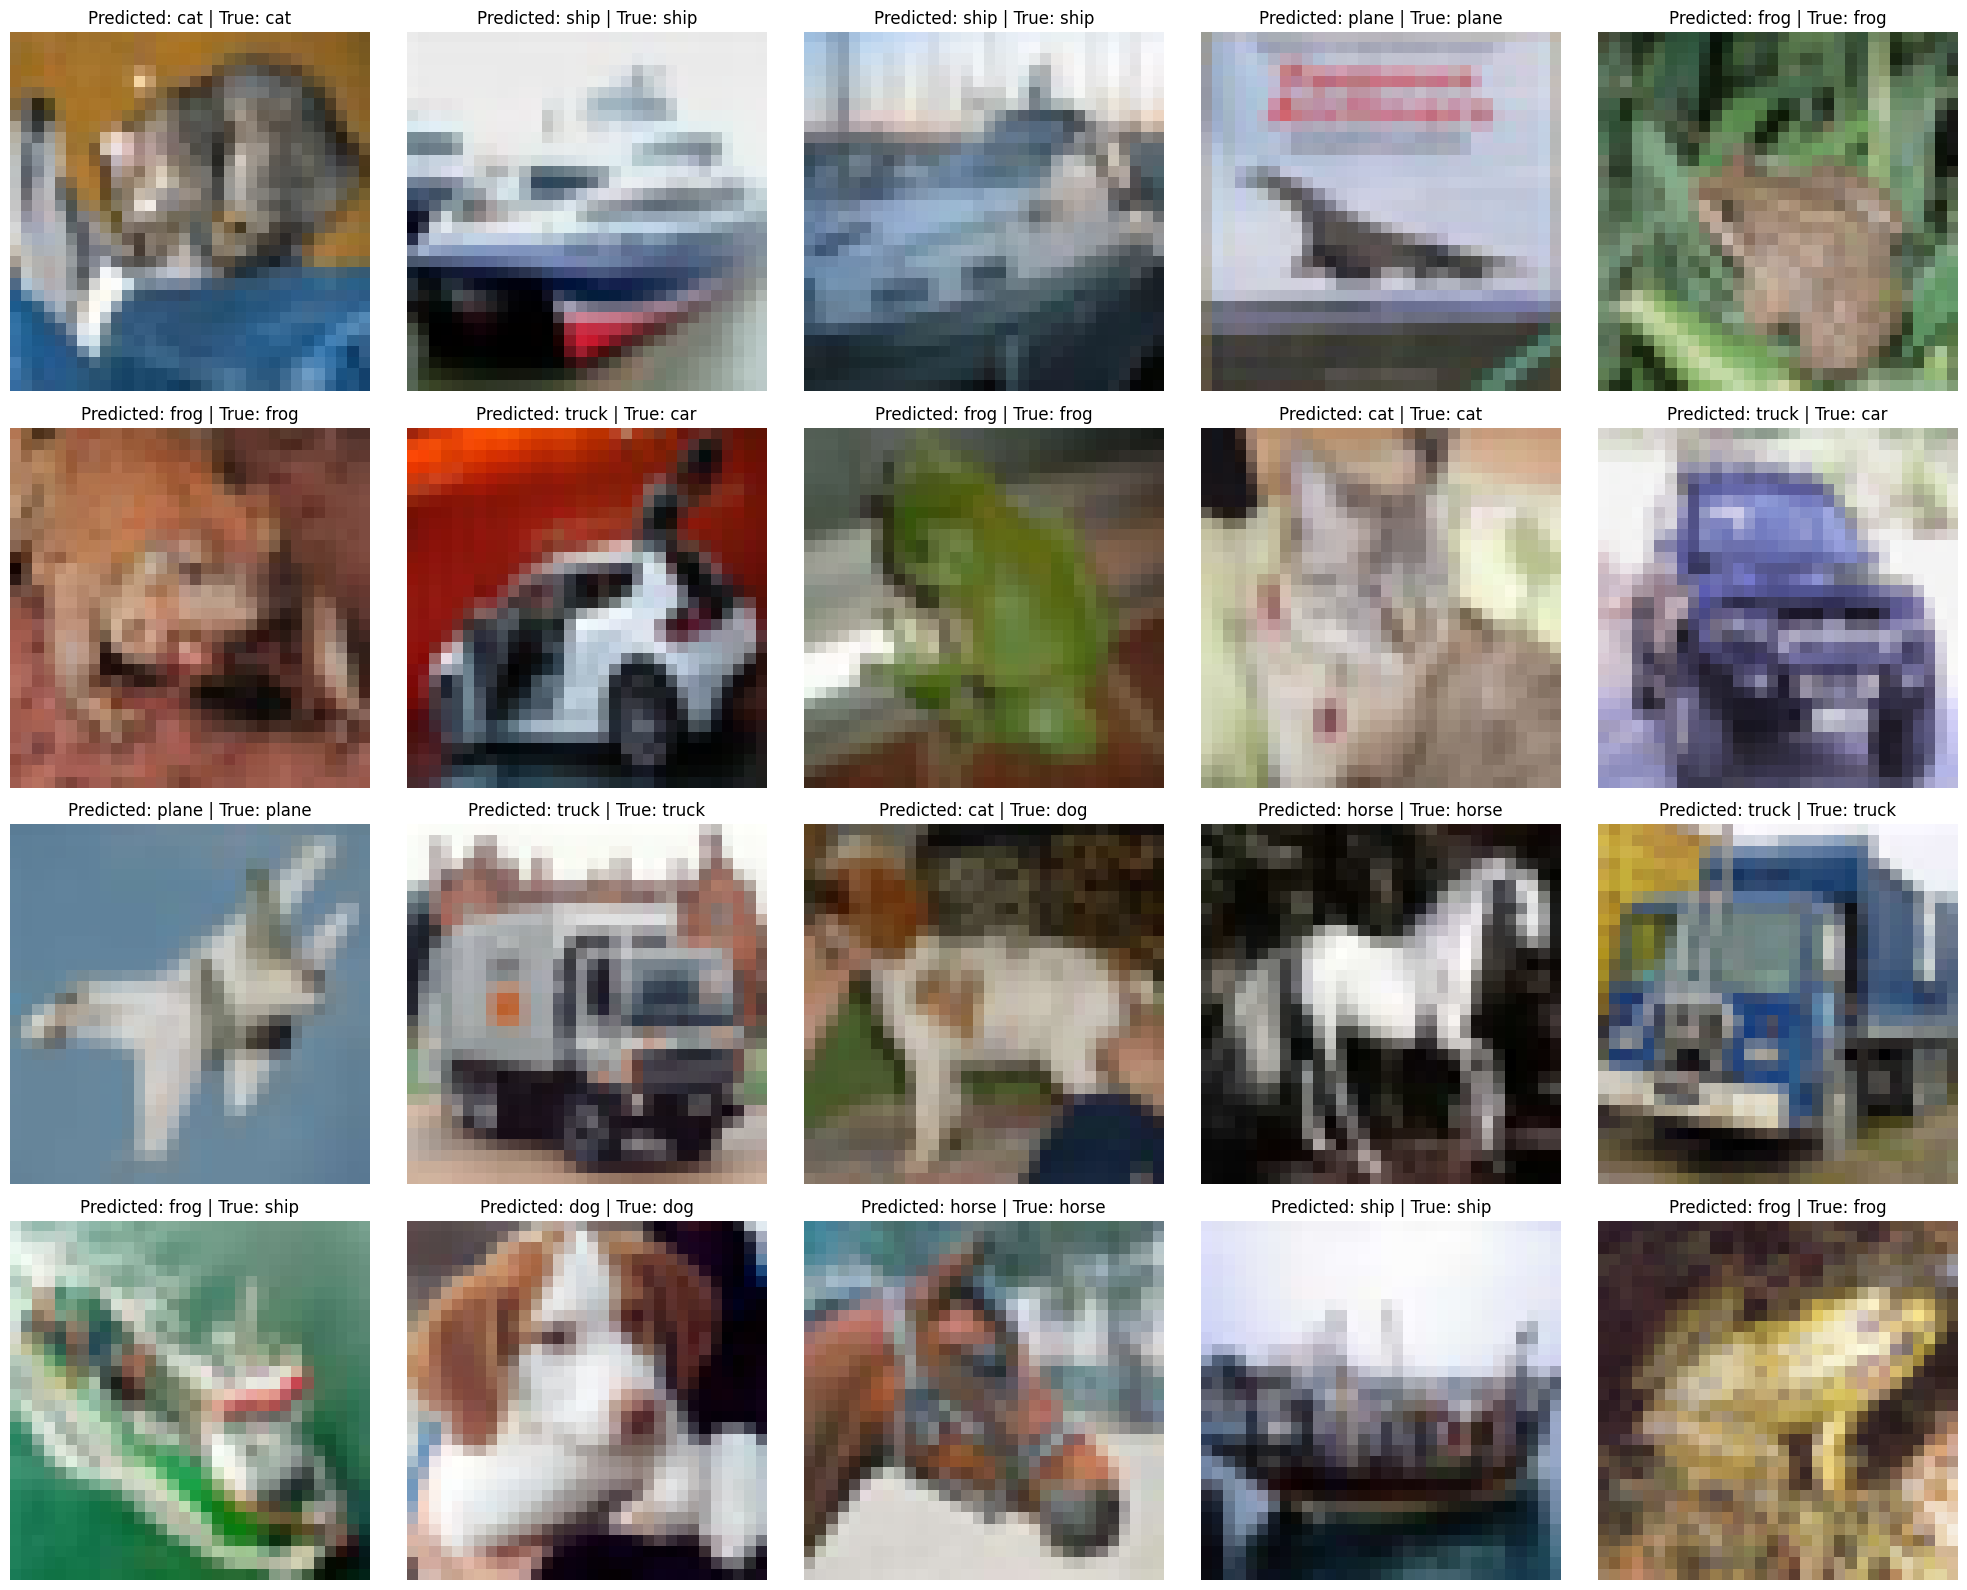

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Tuning learning rate and optimzer
# Train the model
trainloader, testloader, classes = load_cifar10(batch_size=32, num_workers=4) # Tuning batch
print("Training on:", device)
train_losses = train(model, trainloader, criterion, optimizer, epochs=10, device=device)

# Evaluate the model
accuracy = evaluate(model, testloader, device)
print(f'Accuracy on test set: {accuracy:.2f}%')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.show()

display_predictions(testloader, model, device, num_images=20)